In [25]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
import json


In [2]:
mode = 'TRAIN' # TRAIN/TEST

batch_size = 64

In [3]:
session = tf.InteractiveSession()

In [24]:
# turn digitStruct.mat into json:

from digitStruct import yieldNextDigitStruct

for dataset in ['train', 'test']:
    dir = '../data/svhn/' + dataset

    filename_labels = {}

    for struct in yieldNextDigitStruct(os.path.join(dir, 'digitStruct.mat')):
        digits = "".join([str(bbox.label) for bbox in struct.bboxList])
        filename_labels[struct.name] = digits

    # filenames = filename_labels.keys()
    # labels = [filename_labels[fn] for fn in filenames]
    open(os.path.join(dir, 'labels.json'), 'w').write(json.dumps(filename_labels))
    print dataset


train
test


In [42]:
# filename_queue = tf.train.string_input_producer(filenames, num_epochs=(1 if mode == 'TEST' else None))
# reader = tf.WholeFileReader()
# filename, content = reader.read(filename_queue)
# images = tf.image.decode_png(content)
# tf.train.start_queue_runners()

dir = '../data/svhn/' + ('train' if mode == 'TRAIN' else 'test')
filename_labels = json.load(open(os.path.join(dir, 'labels.json')))
filenames = filename_labels.keys()
# print max(filename_labels.values(), key=len)
max_len = 7
label_matrix = np.zeros((len(filenames), max_len), dtype=int)
label_matrix.fill(10)
for i, filename in enumerate(filenames):
    digits = '0123456789'
    for j, digit in enumerate(filename_labels[filename]):
        label_matrix[i, j] = digits.index(digit)

filename_tensor = tf.convert_to_tensor([os.path.join(dir, fn) for fn in filenames], dtype=tf.string)
label_tensor = tf.convert_to_tensor(label_matrix, dtype=tf.int32)
num_epochs = None if mode == 'TRAIN' else 1

filename_q, label_q = tf.train.slice_input_producer([filename_tensor, label_tensor], num_epochs=num_epochs, shuffle=True)
image_q = tf.image.decode_png(tf.read_file(filename_q))

tf.train.start_queue_runners()


[<Thread(Thread-12, started daemon 140685529306880)>]

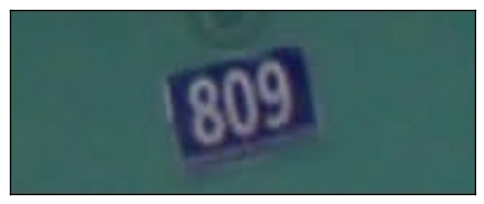

[ 8  1  0  9 10 10 10]


In [60]:
%matplotlib inline

image, label = session.run([image_q, label_q])
imshow_multi([image / 255.0])
print label

In [ ]:
filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    rarity_tensor = tf.convert_to_tensor(rarity_vector, dtype=tf.float32)
    filename_q, attr_q, rarity_q = tf.train.slice_input_producer([filename_tensor, attr_tensor, rarity_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218


    def resize_image(image):
        image = tf.random_crop(image, [192, 160, 3])
        return image
    #     image = tf.image.resize_bilinear(img_reshaped, [192, 160])
    #     return tf.reshape(image, [192, 160, 3])
    image = resize_image(image)

    def distort_image(image):
        distorted_image = tf.image.random_flip_left_right(image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    image = distort_image(image) if train else image

    if train:
        images_batch, attrs_batch, rarity_batch = tf.train.shuffle_batch([image, attr_q, rarity_q], batch_size=BATCH_SIZE, capacity=1000, min_after_dequeue=500)
    else:
        images_batch, attrs_batch, rarity_batch = tf.train.batch([image, attr_q, rarity_q], batch_size=BATCH_SIZE, allow_smaller_final_batch=True)
    return images_batch, attrs_batch, rarity_batch